### CSCA 5642 University of Colorado Boulder Deep Learning Final Project 
# Detecting Patterns in Cardiovascular Disease for Early and Targeted Invervention
*Samuel A. Phillips 3/27/25*

*Repo Link: https://github.com/samuelaphillips/intro-deeplearning-final*

## Problem Statement

Cardiovascular diseases (CVDs) are the leading cause of death worldwide, with heart failure being one of the most prevalent and deadly outcomes among CVD patients. In light of this, it is crucial to develop effective systems for identifying patterns in the progression of cardiovascular diseases, allowing for early intervention and prevention of fatal outcomes. However, due to the sparse and inconsistent nature of electronic medical records, obtaining clean and complete data across all categories of medical events is not always feasible. This highlights the need to explore data augmentation techniques to improve predictive modeling.

For this project, we will use a dataset collected from the Faisalabad Institute of Cardiology and Allied Hospital in Faisalabad. It includes 12 features—such as age, creatinine phosphokinase levels, and sex—which are either binary categorical or numerical. The target variable for our binary classification task is the “Death Event” column, indicating whether a patient died between the heart failure episode and the time of data collection.

Our primary objective is to investigate data augmentation using different types of autoencoders. While autoencoders are not commonly applied to tabular data—and some experts advise against using them for dimensionality reduction in such contexts—we aim to experiment with augmenting inputs using their encoded representations, rather than relying solely on the encoded data. We will explore traditional autoencoders and variational autoencoders, which have been covered in our coursework. Additionally, we will implement orthogonality-enforced autoencoders, a novel approach proposed by Cha and Thiyagalingam [2]. This method aims to ensure that each feature in the latent space captures distinct information by minimizing the deviation of the encoded data's covariance matrix from the identity matrix, thereby promoting orthogonality in the latent space.

In [1]:
# general imports
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler

# custom helper functions; contains statistics wrappers and visualization functions
from helpers.metrics import *

# tensorflow stuff
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# please, no warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
os.environ['PYTHONWARNINGS']='ignore'

## Iterative Data Cleaning and EDA

### Import 


In [23]:
# Import datasets
df = pd.read_csv('./Data/heart_failure_clinical_records_dataset.csv')
labels = df['DEATH_EVENT']
df = df.drop(columns=['DEATH_EVENT'])

We will begin by splitting the dataset. In academic or non-industry settings, it is generally recommended to perform the split before data cleaning and exploratory data analysis (EDA) to minimize the risk of data leakage from the validation set. In contrast, industry practices tend to be more flexible regarding when the split occurs, as long as proper training and validation splits are maintained. Since this project emphasizes sample efficiency, our goal is to achieve strong model performance using the smallest amount of information possible.

In [24]:
X_train, X_test, y_train, y_test =  train_test_split(df, labels, test_size=0.2, random_state=42)

In [25]:
print(f" train feature set size: {len(X_train)},\n test feature set size: {len(X_test)},\n train label set size: {len(y_train)},\n test label set size: {len(y_test)},\n original data frame size: {len(df)}")

 train feature set size: 239,
 test feature set size: 60,
 train label set size: 239,
 test label set size: 60,
 original data frame size: 299


### Description of Data



The dataset is tabular and consists of 13 features—12 used as input variables and one as the target label—across 299 samples. The input features include a balanced mix of nominal categorical data and numerical data, both discrete and continuous. Examples of nominal categorical features include sex/gender and whether the patient has a history of high blood pressure. There are no ordinal categorical features or multi-class nominal features, which simplifies the preprocessing. As expected for a binary classification task, the target label is a binary nominal categorical variable.

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 239 entries, 6 to 102
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       239 non-null    float64
 1   anaemia                   239 non-null    int64  
 2   creatinine_phosphokinase  239 non-null    int64  
 3   diabetes                  239 non-null    int64  
 4   ejection_fraction         239 non-null    int64  
 5   high_blood_pressure       239 non-null    int64  
 6   platelets                 239 non-null    float64
 7   serum_creatinine          239 non-null    float64
 8   serum_sodium              239 non-null    int64  
 9   sex                       239 non-null    int64  
 10  smoking                   239 non-null    int64  
 11  time                      239 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 24.3 KB


In [27]:
X_train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
6,75.000,1,246,0,15,0,127000.00,1.20,137,1,0,10
183,75.000,0,99,0,38,1,224000.00,2.50,134,1,0,162
185,60.667,1,104,1,30,0,389000.00,1.50,136,1,0,171
146,52.000,0,132,0,30,0,218000.00,0.70,136,1,1,112
30,94.000,0,582,1,38,1,263358.03,1.83,134,1,0,27


In [28]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 239 entries, 6 to 102
Series name: DEATH_EVENT
Non-Null Count  Dtype
--------------  -----
239 non-null    int64
dtypes: int64(1)
memory usage: 3.7 KB


### Missing Values

While our data description indicated there are no null values, we will verify this to be sure.

In [29]:
# there are 96 total null values
X_train.isna().sum().sum()

np.int64(0)

### Distribution and Analysis of the "Time" Feature

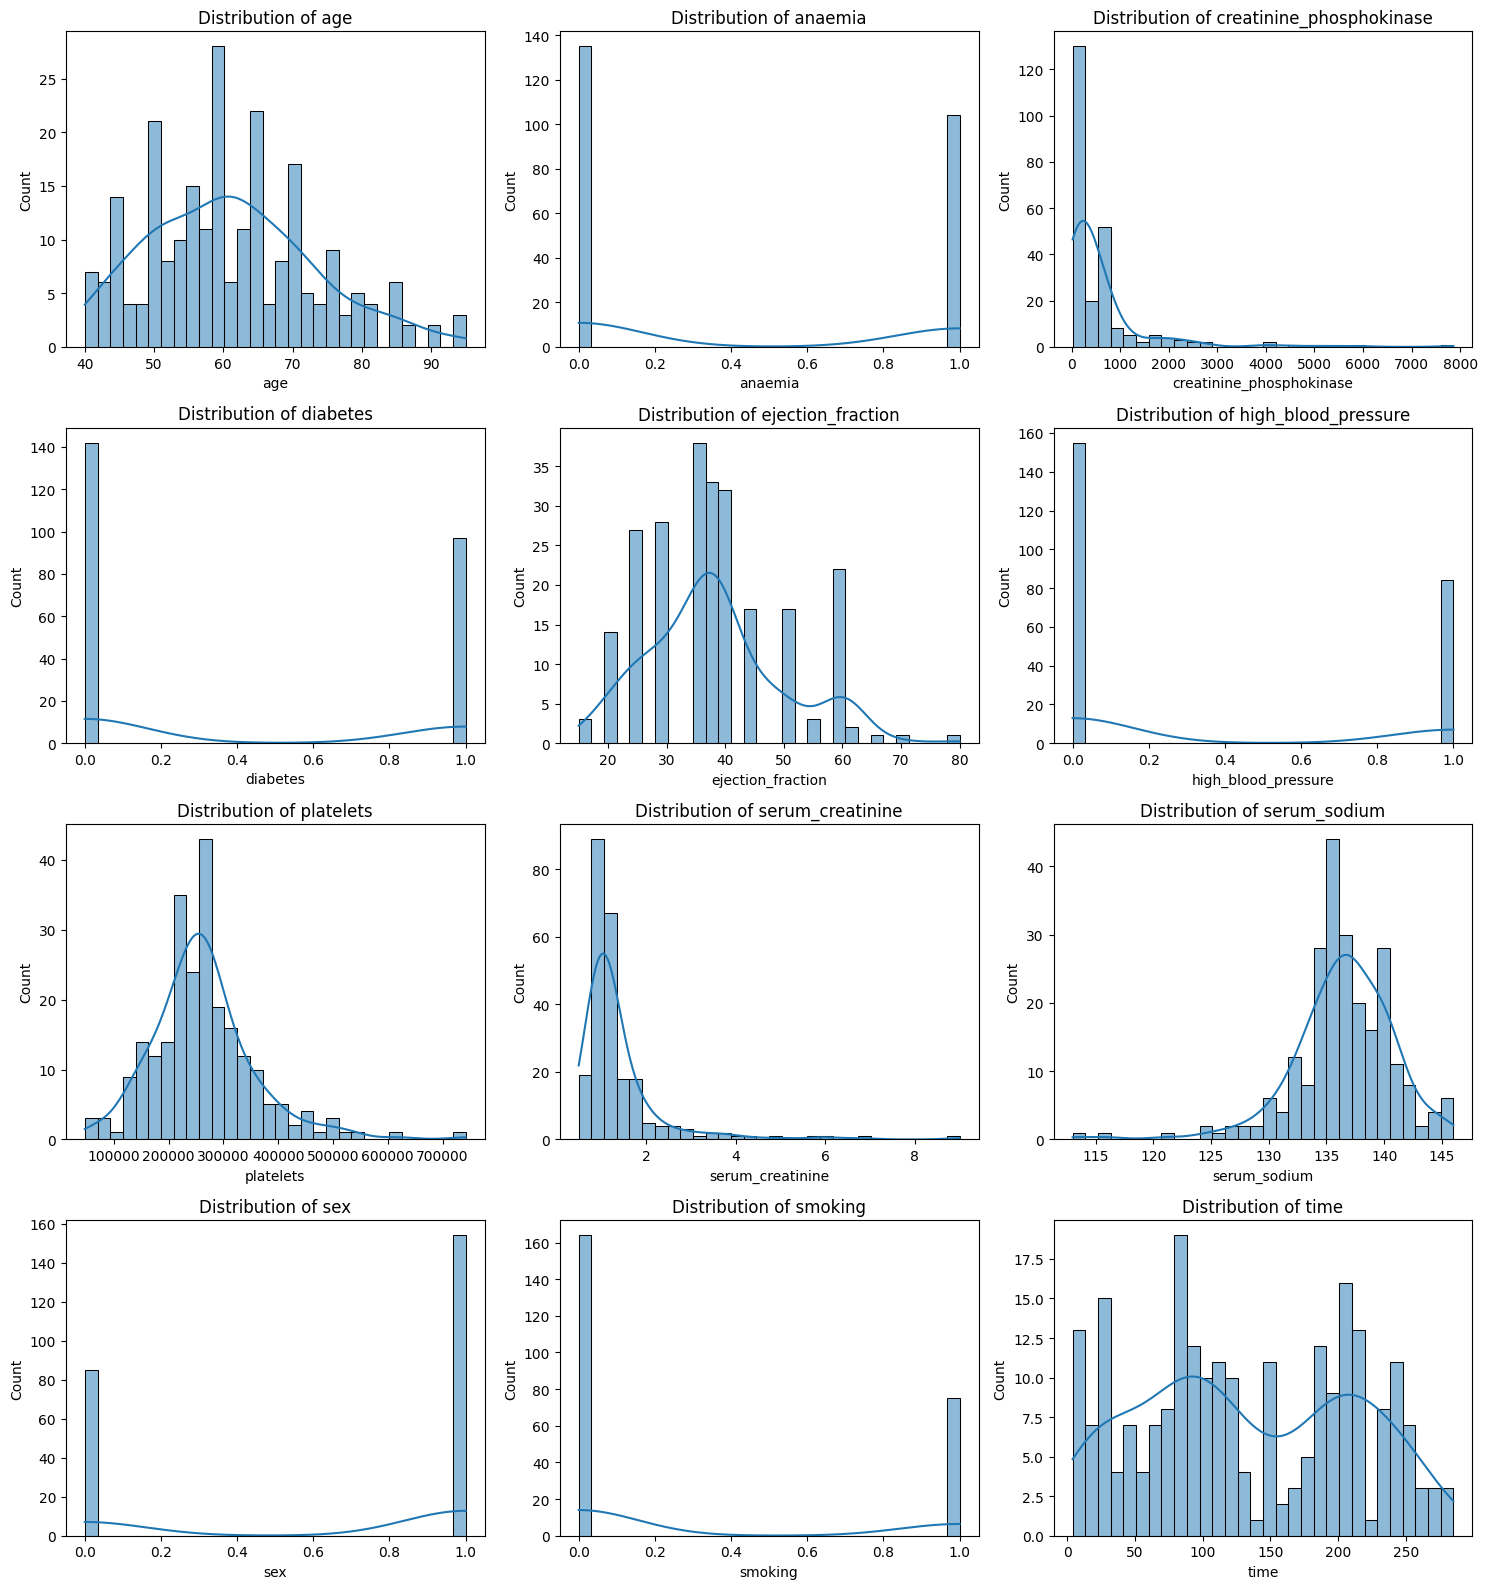

In [30]:
num_cols = len(X_train.columns)
rows, cols = math.ceil(num_cols / 3), min(3, num_cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for ax, col in zip(axes, X_train.columns):
    sns.histplot(X_train[col], bins=30, kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')

# Hide unused subplots
for ax in axes[num_cols:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

In this dataset, the **"Time"** feature represents the duration between the last follow-up examination and the heart failure event. For patients who passed away, it indicates the time between the heart failure event and their death. This distinction is reflected in the bimodal distribution of the data: the first peak, with a shorter average duration, corresponds to patients who died, while the second peak aligns with those who survived. Since this feature provides an overly strong predictive signal, we will exclude it from the dataset.

In [31]:
X_train = X_train.drop(columns=['time'])
X_test = X_test.drop(columns=['time'])

In [32]:
print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 239 entries, 6 to 102
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       239 non-null    float64
 1   anaemia                   239 non-null    int64  
 2   creatinine_phosphokinase  239 non-null    int64  
 3   diabetes                  239 non-null    int64  
 4   ejection_fraction         239 non-null    int64  
 5   high_blood_pressure       239 non-null    int64  
 6   platelets                 239 non-null    float64
 7   serum_creatinine          239 non-null    float64
 8   serum_sodium              239 non-null    int64  
 9   sex                       239 non-null    int64  
 10  smoking                   239 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 22.4 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 281 to 59
Data columns (total 11 columns):
 #   Column                  

### Handling For Outliers

Below are box plots for each of the features in the dataset:

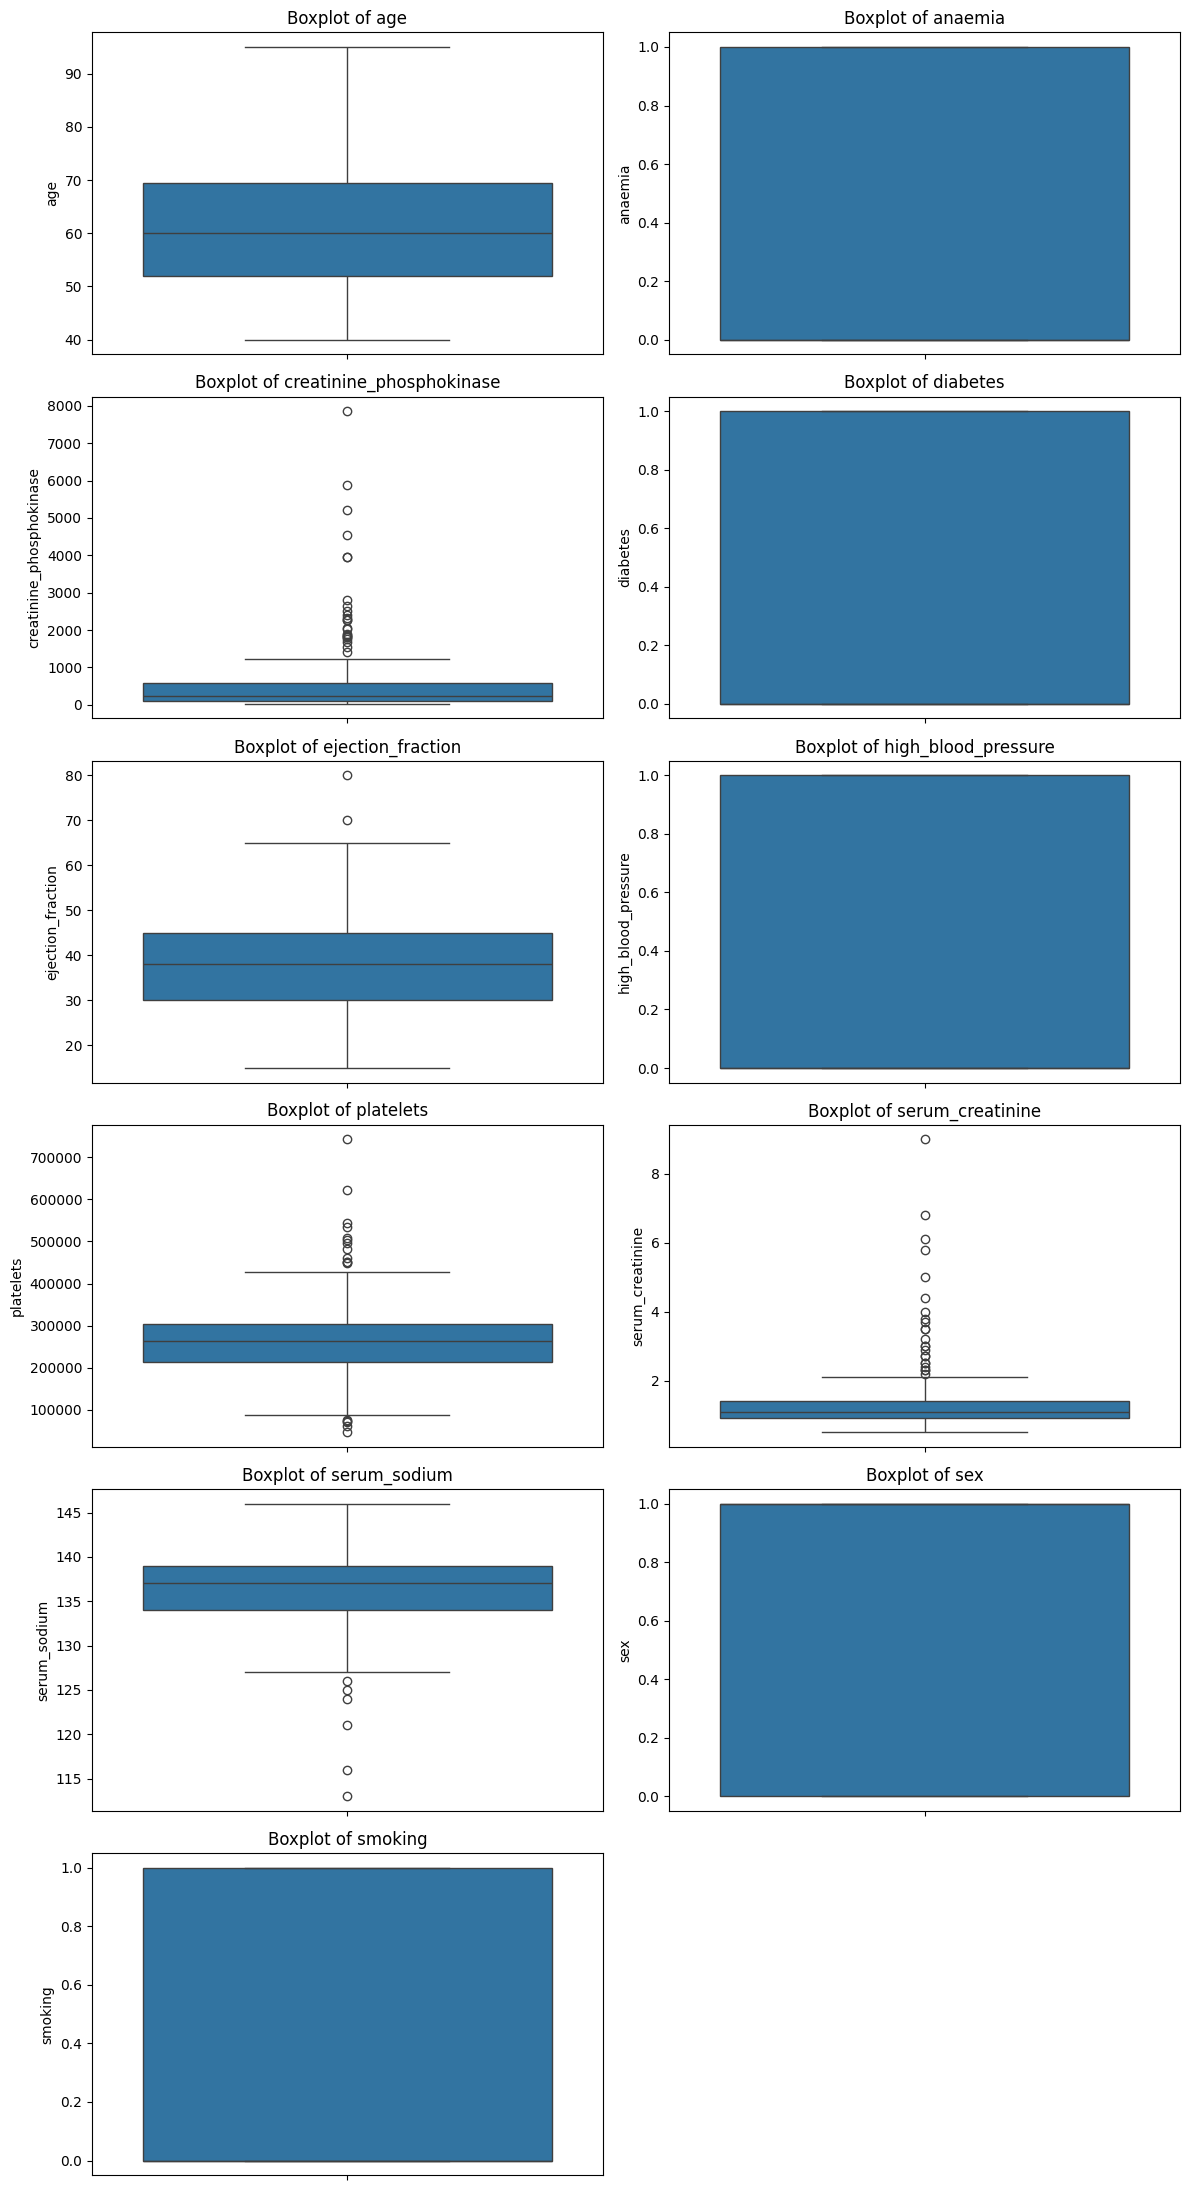

In [33]:
num_features = len(X_train.columns)

fig, axes = plt.subplots(nrows=(num_features // 2) + 1, ncols=2, figsize=(12, num_features * 2))
axes = axes.flatten()

for i, col in enumerate(X_train.columns):
    sns.boxplot(y=X_train[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [34]:
Q1 = X_train['creatinine_phosphokinase'].quantile(0.25)
Q3 = X_train['creatinine_phosphokinase'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = X_train[(X_train['creatinine_phosphokinase'] < lower_bound) | (X_train['creatinine_phosphokinase'] > upper_bound)]
outliers

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
283,65.0,0,1688,0,38,0,263358.03,1.10,138,1,1
296,45.0,0,2060,1,60,0,742000.00,0.80,138,0,0
72,85.0,0,5882,0,35,0,243000.00,1.00,132,1,1
246,55.0,0,2017,0,25,0,314000.00,1.10,138,1,0
139,50.0,0,1548,0,30,1,211000.00,0.80,138,1,0
38,60.0,0,2656,1,30,0,305000.00,2.30,137,1,0
176,69.0,0,1419,0,40,0,105000.00,1.00,135,1,1
208,60.0,1,2281,1,40,0,283000.00,1.00,141,0,0
107,45.0,1,1876,1,35,0,226000.00,0.90,138,1,0
250,50.0,0,2522,0,30,1,404000.00,0.50,139,0,0


In [35]:
print(len(outliers))

24


The dataset contains a large number of outliers relative to its size, with around 10% of the data points in the creatinine phosphokinase feature alone flagged as outliers. Given this, we will use a robust scaler, as it is less sensitive to outliers and better preserves potentially meaningful extremes. For example, extremely high creatinine phosphokinase levels may indicate critical medical conditions.

### Addressing multicollinearity

We will do a quick check to see if there are any correlated features. If so, we will remove the redundant features to decrease noise.

In [36]:
X_train.corr()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
age,1.000000,0.075484,-0.047069,-0.103526,0.020804,0.069992,0.000475,0.119166,-0.065063,0.063091,-0.032755
anaemia,0.075484,1.000000,-0.167715,-0.003595,0.028008,0.060945,-0.045011,0.018905,0.052352,-0.088370,-0.138876
creatinine_phosphokinase,-0.047069,-0.167715,1.000000,-0.063066,-0.013758,-0.120585,-0.011842,0.018959,0.079775,0.060299,0.052583
diabetes,-0.103526,-0.003595,-0.063066,1.000000,0.008377,-0.037337,0.086682,-0.043117,-0.135737,-0.169129,-0.154961
ejection_fraction,0.020804,0.028008,-0.013758,0.008377,1.000000,0.049641,0.084689,0.007005,0.170855,-0.119223,-0.078148
high_blood_pressure,0.069992,0.060945,-0.120585,-0.037337,0.049641,1.000000,0.030705,-0.039177,0.070915,-0.057220,-0.063454
platelets,0.000475,-0.045011,-0.011842,0.086682,0.084689,0.030705,1.000000,-0.069992,0.046123,-0.151702,-0.014396
serum_creatinine,0.119166,0.018905,0.018959,-0.043117,0.007005,-0.039177,-0.069992,1.000000,-0.221415,-0.041322,-0.088745
serum_sodium,-0.065063,0.052352,0.079775,-0.135737,0.170855,0.070915,0.046123,-0.221415,1.000000,-0.060037,0.013470
sex,0.063091,-0.088370,0.060299,-0.169129,-0.119223,-0.057220,-0.151702,-0.041322,-0.060037,1.000000,0.445903


<Axes: >

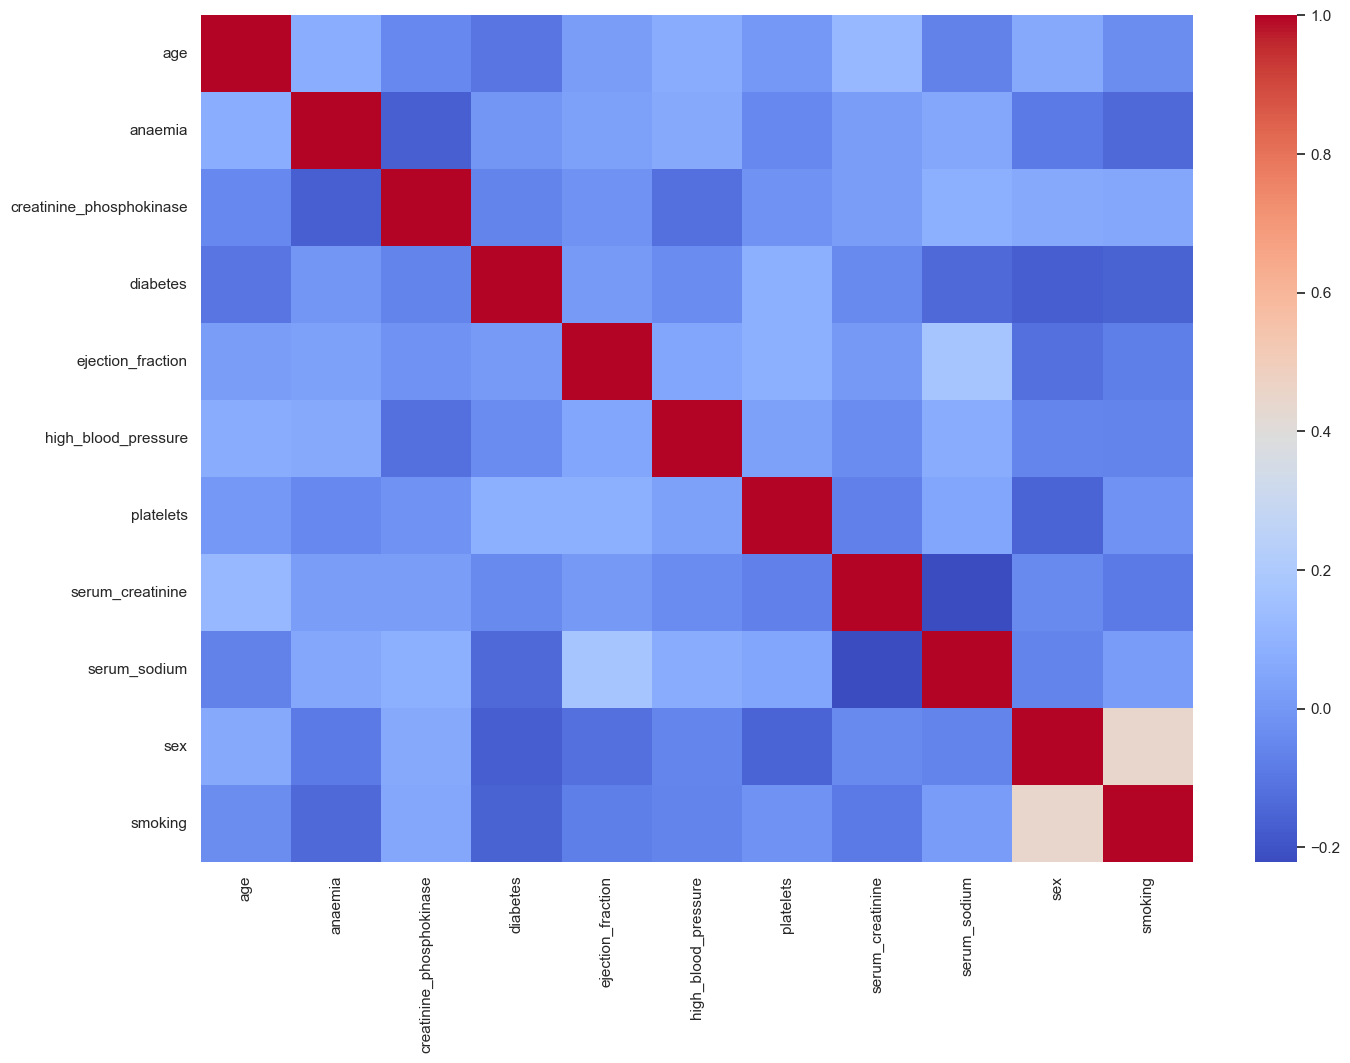

In [37]:
plt.figure(figsize=(16, 11))
sns.set(
    rc = {
        'font.size':9
    }
)
sns.heatmap(X_train.corr(), annot=False, cmap="coolwarm")

In [38]:
# We will drop features that have greater than 0.95 correlation but less than .99
# Make sure to only use train set
corr = X_train.corr().abs()

to_drop = set()

columns = corr.columns
for i in range(len(columns)):
    for j in range(i+1,len(columns)):
        if corr.iloc[i][j] > 0.95:
            to_drop.add(columns[i])
            print(corr.iloc[i][j])
            break
            
print(len(columns), len(to_drop))
print(list(to_drop))

X_train.drop(list(to_drop), axis=1, inplace=True)
X_test.drop(list(to_drop), axis=1, inplace=True)


11 0
[]


Fortunately, there are no highly correlated features in the dataset, which means we can retain all the existing features for modeling.

In [39]:
print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 239 entries, 6 to 102
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       239 non-null    float64
 1   anaemia                   239 non-null    int64  
 2   creatinine_phosphokinase  239 non-null    int64  
 3   diabetes                  239 non-null    int64  
 4   ejection_fraction         239 non-null    int64  
 5   high_blood_pressure       239 non-null    int64  
 6   platelets                 239 non-null    float64
 7   serum_creatinine          239 non-null    float64
 8   serum_sodium              239 non-null    int64  
 9   sex                       239 non-null    int64  
 10  smoking                   239 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 22.4 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 281 to 59
Data columns (total 11 columns):
 #   Column                  

### Checking imbalance


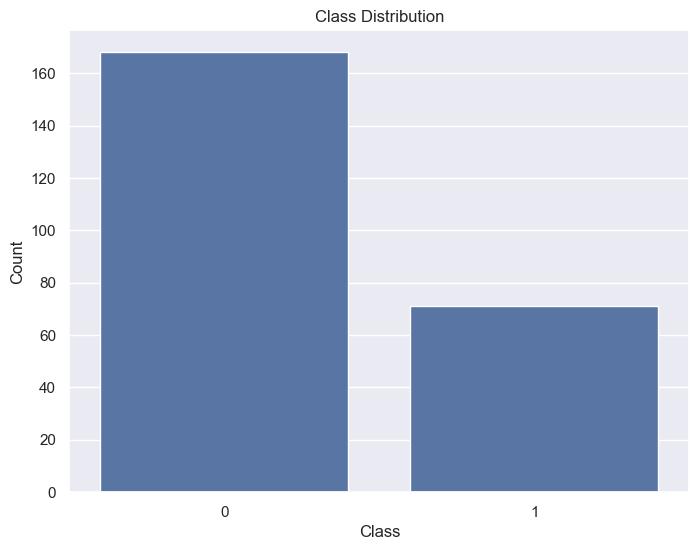

In [40]:
class_counts = y_train.value_counts()

# bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Due to the significant class imbalance, we will apply SMOTE to generate synthetic samples for the minority class. This must be done **before** feature scaling, as SMOTE operates in the original feature space, and scaling beforehand could distort the relationships between features. As always, this process will be applied **only** to the training set to prevent data leakage.

In [41]:
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [42]:
print(f" train feature set size: {len(X_train)},\n test feature set size: {len(X_test)},\n train label set size: {len(y_train)},\n test label set size: {len(y_test)},\n original data frame size: {len(df)}")

 train feature set size: 336,
 test feature set size: 60,
 train label set size: 336,
 test label set size: 60,
 original data frame size: 299


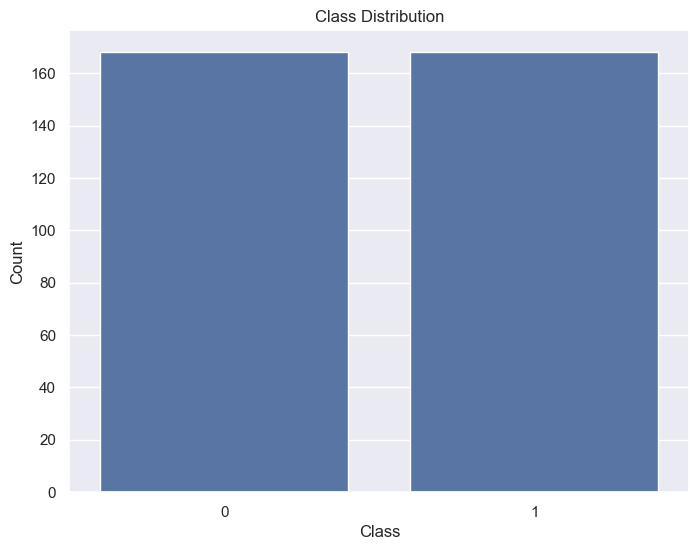

In [43]:
class_counts = y_train.value_counts()

# bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### Feature Scaling

We will conclude the EDA by applying robust scaling. Both the training and test sets will be scaled, but the scaler will be fitted only on the training data to prevent information leakage.

In [44]:
scaler = RobustScaler()

to_scale = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']

X_train_scaled = scaler.fit_transform(X_train[to_scale])
X_test_scaled = scaler.transform(X_test[to_scale])

In [45]:
X_train[to_scale] = X_train_scaled
X_test[to_scale] = X_test_scaled

In [46]:
X_train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,0.859276,1,-0.026345,0,-1.632653,0,-1.233864,0.000000,0.2,1,0
1,0.859276,0,-0.349067,0,0.244898,1,-0.302971,1.881916,-0.4,1,0
2,-0.025914,1,-0.338090,1,-0.408163,0,1.280506,0.434288,0.0,1,0
3,-0.561179,0,-0.276619,0,-0.408163,0,-0.360552,-0.723814,0.0,1,1
4,2.032696,0,0.711306,1,0.244898,1,0.074741,0.912005,-0.4,1,0


In [47]:
X_test.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
281,0.550482,0,0.711306,0,0.408163,0,-1.963223,2.171441,0.0,1,1
265,-0.684697,1,0.087816,0,0.000000,0,1.021391,-0.434288,0.8,1,1
164,-0.993492,0,4.794731,1,-0.408163,0,0.752680,-0.144763,0.6,1,0
9,1.168071,1,-0.296378,0,0.000000,1,1.270909,11.870546,-0.6,1,1
77,-1.178768,0,-0.342481,1,0.408163,0,-0.178212,0.000000,0.8,1,0


### Data Cleaning and EDA Conclusion

In this data cleaning and EDA section, we began by examining the distributions of the input features and decided to remove the "Time" feature, as it provides information that would not be available at the moment of a heart failure event. Next, we reviewed the box plots and observed a high number of outliers relative to the dataset size, which led us to choose robust scaling instead of removing samples, as the outliers may carry important clinical significance. We then analyzed feature correlations and found none to be highly correlated, allowing us to retain all features and reinforcing the overall quality and informativeness of the dataset. Afterward, we addressed the class imbalance and determined that SMOTE was necessary to generate synthetic samples for the minority class. Lastly, we completed the EDA process by applying robust scaling, ensuring the scaler was fitted only on the training set to avoid data leakage.

## Models

### Modeling Approach

1. **Baseline Model with Traditional Machine Learning**  
   We will begin by establishing a solid baseline using a machine learning algorithm for our classification task.  
   > - **Linear SVC** with 10-fold cross-validation and **Grid Search** for hyperparameter tuning  

2. **Deep Learning with Autoencoder-Based Data Augmentation**  
   Next, we will implement deep learning models that incorporate data augmentation through various types of autoencoders.

   > - **ANN (-) AE**  
   > > - Architecture includes 3 hidden layers, with the first two having twice the number of nodes as the input size  
   > > - **ReLU** will be used for activation, except for the final layer, which uses **sigmoid**  
   > > - Dropout regularization of **0.2** will be applied before the classifier and before the penultimate layer  
   > > - We will start with a learning rate of **0.00005**, but based on loss/accuracy trends, we will adjust (finalized at **0.001** for consistent experimental conditions)  
   > > - This same architecture and hyperparameters will be maintained for all models using autoencoder-based augmentation to avoid excessive tuning, which could lead to data leakage due to the small dataset size  

   > - **ANN (+) AE**  
   > > - The encoder and decoder will be **symmetrical**, each with 2 hidden layers and dropout regularization in between  
   > > - The latent dimension will be **half the input size** (5 in our case)  
   > > - We'll begin with a learning rate of **0.00005**, adjusting as needed to prevent overfitting of the latent space. This step is critical to ensure generalizable performance when using encoded data for tabular classification  

   > - **ANN (+) Orthogonality Enforced AE**  
   > > - Uses the **same structure** as the traditional AE + ANN model  
   > > - Introduces an **orthogonality loss** term: the covariance matrix of the encoded outputs is compared to the identity matrix, and the sum of the difference reflects the degree of non-orthogonality. This encourages distinct features in the latent space  

   > - **ANN (+) VAE**  
   > > - Also follows the same encoder/decoder/classifier structure as the traditional AE + ANN model  
   > > - However, it implements a **variational autoencoder (VAE)** to model the latent space with a probabilistic approach

In [239]:
# We will keep track of accuracy, precision and recall of each model for summary statistics
summary_stats = {
    'Model': [],
    'Test Accuracy': [],
    'Test Precision': [],
    'Test Recall': [],
    'P-Value': [],
    'Is Significant': []
}

### Linear kernel SVC

In [240]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

parameters = {'loss': ['hinge', 'squared_hinge'],
              'C':np.logspace(-2, 0, 301, base=2)}
svc = LinearSVC(random_state=1)
grid_linsvc = GridSearchCV(svc, parameters, cv=10, n_jobs=-1, scoring='accuracy')

grid_linsvc.fit(X_train, y_train)

best_params = grid_linsvc.best_params_
best_score = grid_linsvc.best_score_

print(f"best params: {best_params}")
print(f"cross validation score: {best_score}")

best params: {'C': np.float64(0.6270562047751306), 'loss': 'hinge'}
cross validation score: 0.7680035650623886


In [241]:
handle_stats(summary_stats, grid_linsvc.best_estimator_, X_test, y_test, "Linear SVC")

Prediction: [1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0
 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1], shape: (60,) 

True Label: [0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1
 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1], shape: (60,) 

Z-Score: 3.0983866769659336 

P-Value: 0.0019457736937391612 

[[29  6]
 [12 13]]
test accuracy: 0.7
test precision: 0.6957637997432606
test recall: 0.6742857142857144


### Simple ANN

In [17]:
model = keras.Sequential([
    keras.layers.Dense(X_train.shape[1]*2, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(X_train.shape[1]*2, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(X_train.shape[1], activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=100,
    restore_best_weights=True
)

In [18]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 24)                  │             312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 24)                  │             600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 12)                  │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              13 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,225 (4.79 KB)

 Trainable params: 1,225 (4.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
### FIT MODEL ###
history = model.fit(
    X_train, y_train,
    epochs=2000,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=0
)

In [243]:
# Process statistics
handle_stats(summary_stats, model, X_test, y_test, "Simple ANN")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction: [1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 0 1], shape: (60,) 

True Label: [0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1
 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1], shape: (60,) 

Z-Score: 3.0983866769659336 

P-Value: 0.0019457736937391612 

[[28  7]
 [11 14]]
test accuracy: 0.7
test precision: 0.6923076923076923
test recall: 0.68


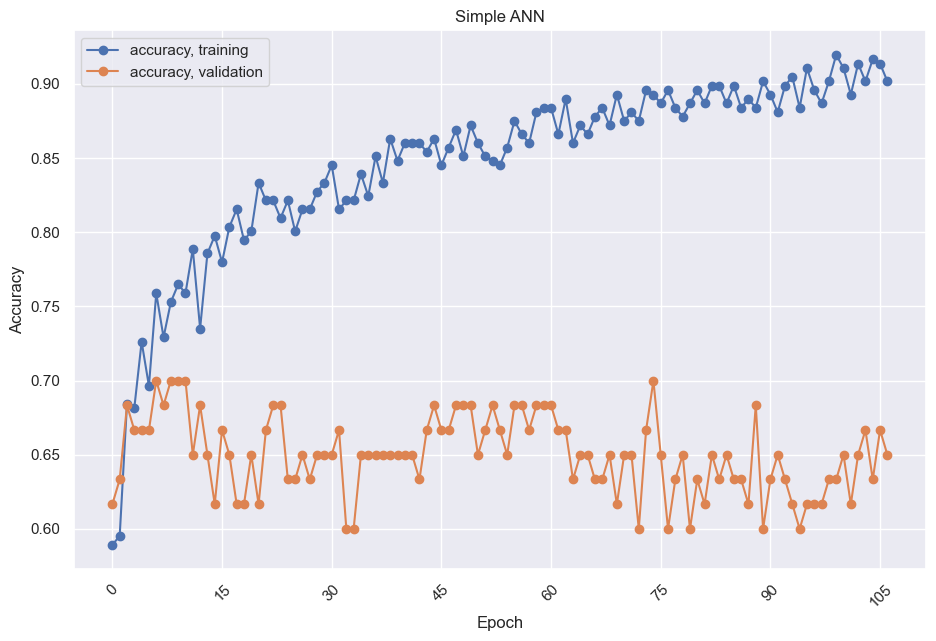

In [244]:
# Plot train-validation accuracy curves
plot_accuracy(history, "Simple ANN")

### ANN + Autoencoder

In [48]:
class Autoencoder(Model):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        
        # ENCODER
        self.encoder = keras.Sequential([
            keras.layers.Dense(input_dim, activation='relu', input_shape=(input_dim,)),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(input_dim//2, activation='relu'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(encoding_dim, activation='relu')
        ])

        # DECODER
        self.decoder = keras.Sequential([
            keras.layers.Dense(input_dim//2, activation='relu', input_shape=(encoding_dim,)),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(input_dim, activation='relu'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(input_dim, activation=None)
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        reconstructed = self.decoder(encoded)
        return reconstructed
        
num_features = X_train.shape[1]
encoding_dim = X_train.shape[1] // 2
autoencoder = Autoencoder(num_features, encoding_dim)

# optimizer = tf.keras.optimizers.Adam()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.MeanSquaredError()

def train_autoencoder(model, X_train, X_test, epochs=50, batch_size=16):
    dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(batch_size)
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        
        # training step
        for batch in dataset:
            with tf.GradientTape() as tape:
                reconstructed = model(batch)
                loss = loss_fn(batch, reconstructed)
            
            # compute gradients and update weights
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            epoch_loss += loss.numpy()

        # calculate validation loss
        val_reconstructed = model(X_test)
        val_loss = loss_fn(X_test, val_reconstructed).numpy()

        if (epoch+1) % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f}")

In [49]:
autoencoder.encoder.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 11)                  │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 11)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 5)                   │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 5)                   │              30 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 222 (888.00 B)

 Trainable params: 222 (888.00 B)

 Non-trainable params: 0 (0.00 B)

In [50]:
autoencoder.decoder.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                     │ (None, 5)                   │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 11)                  │              66 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 11)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 11)                  │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 228 (912.00 B)

 Trainable params: 228 (912.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_autoencoder(autoencoder, np.array(X_train), np.array(X_test), epochs=500, batch_size=100)

X_train_encoded = autoencoder.encoder(np.array(X_train)).numpy()
X_test_encoded = autoencoder.encoder(np.array(X_test)).numpy()

test_reconstructed = autoencoder(np.array(X_test))
test_loss = loss_fn(np.array(X_test), test_reconstructed).numpy()
print(f"\nTest Reconstruction Loss: {test_loss:.4f}")

Epoch 100/500 - Loss: 1.2976 - Val Loss: 0.4137
Epoch 200/500 - Loss: 1.0273 - Val Loss: 0.3183
Epoch 300/500 - Loss: 0.8237 - Val Loss: 0.2435
Epoch 400/500 - Loss: 0.7568 - Val Loss: 0.2244
Epoch 500/500 - Loss: 0.7360 - Val Loss: 0.2193

Test Reconstruction Loss: 0.2193


In [52]:
X_train_encoded = autoencoder.encoder(np.array(X_train)).numpy()
X_test_encoded = autoencoder.encoder(np.array(X_test)).numpy()

In [53]:
X_train_augmented = pd.concat([X_train,  pd.DataFrame(X_train_encoded)], axis=1)
X_test_augmented = pd.concat([X_test.reset_index(drop=True),  pd.DataFrame(X_test_encoded)], axis=1)

In [54]:
print(len(np.array(X_train)[0]), len(np.array(X_train_augmented)[0]))
print(len(np.array(X_test)[0]), len(np.array(X_test_augmented)[0]))

11 16
11 16


In [55]:
model = keras.Sequential([
    keras.layers.Dense(X_train_augmented.shape[1]*2, activation='relu', input_shape=(X_train_augmented.shape[1],)),
    keras.layers.Dense(X_train_augmented.shape[1]*2, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(X_train_augmented.shape[1], activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=100,
    restore_best_weights=True
)

In [56]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,145 (8.38 KB)

 Trainable params: 2,145 (8.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
### FIT MODEL ###
history = model.fit(
    X_train_augmented, y_train,
    epochs=2000,
    batch_size=32,
    validation_data=(X_test_augmented, y_test),
    callbacks=[early_stopping],
    verbose=0
)

In [250]:
handle_stats(summary_stats, model, X_test_augmented, y_test, "ANN + AE")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction: [1 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0
 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0 1 0 1], shape: (60,) 

True Label: [0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1
 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1], shape: (60,) 

Z-Score: 3.6147844564602556 

P-Value: 0.0003005976074403893 

[[29  6]
 [10 15]]
test accuracy: 0.7333333333333333
test precision: 0.728937728937729
test recall: 0.7142857142857143


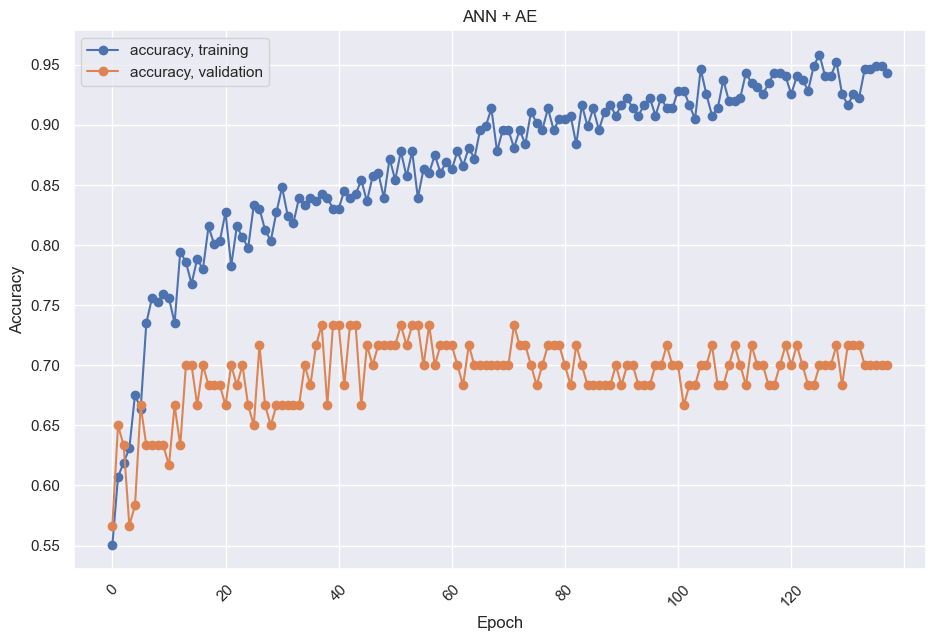

In [251]:
plot_accuracy(history, "ANN + AE")

### Linear SVC with the encoded data

In [252]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

parameters = {'loss': ['hinge', 'squared_hinge'],
              'C':np.logspace(-2, 0, 301, base=2)}
svc = LinearSVC(random_state=1)
grid_linsvc = GridSearchCV(svc, parameters, cv=10, n_jobs=-1, scoring='accuracy')

grid_linsvc.fit(np.array(X_train_augmented), np.array(y_train))

best_params = grid_linsvc.best_params_
best_score = grid_linsvc.best_score_

print(f"best params: {best_params}")
print(f"cross validation score: {best_score}")


best params: {'C': np.float64(0.2618235307051567), 'loss': 'hinge'}
cross validation score: 0.7651515151515152


In [253]:
handle_stats(summary_stats, grid_linsvc.best_estimator_, np.array(X_test_augmented), y_test, "Linear SVC + AE")

Prediction: [1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0
 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1], shape: (60,) 

True Label: [0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1
 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1], shape: (60,) 

Z-Score: 3.0983866769659336 

P-Value: 0.0019457736937391612 

[[29  6]
 [12 13]]
test accuracy: 0.7
test precision: 0.6957637997432606
test recall: 0.6742857142857144


### Orthogonality enforced autoencoder

reference: Jaehoon Cha and Jeyan Thiyagalingam. 2023. Orthogonality-enforced latent space in autoencoders: an approach to learning disentangled representations. In Proceedings of the 40th International Conference on Machine Learning (ICML'23), Vol. 202. JMLR.org, Article 157, 3913–3948.


In [57]:
class AutoencoderOrtho(Model):
    def __init__(self, input_dim, encoding_dim):
        super(AutoencoderOrtho, self).__init__()

        # ENCODER
        self.encoder = keras.Sequential([
            keras.layers.Dense(input_dim, activation='relu', input_shape=(input_dim,)),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(input_dim//2, activation='relu'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(encoding_dim, activation='relu')
        ])

        # DECODER
        self.decoder = keras.Sequential([
            keras.layers.Dense(input_dim//2, activation='relu', input_shape=(encoding_dim,)),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(input_dim, activation='relu'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(input_dim, activation=None)
        ])
        
    def call(self, inputs):
        encoded = self.encoder(inputs)
        reconstructed = self.decoder(encoded)
        return reconstructed


num_features = X_train.shape[1]
encoding_dim = X_train.shape[1] // 2
autoencoder_ortho = AutoencoderOrtho(num_features, encoding_dim)

# optimizer = tf.keras.optimizers.Adam()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.MeanSquaredError()
        
def orthogonality_loss(z):
    z_t = tf.transpose(z)
    z_product = tf.matmul(z_t, z)
    identity = tf.eye(z_product.shape[0])
    ortho_loss = tf.reduce_mean(tf.square(z_product - identity))

    # print(z.shape, z_t.shape, z_product.shape, identity.shape)
    # print("ortho loss: ", ortho_loss)
    return ortho_loss

def train_autoencoder_ortho(model, X_train, X_test, epochs=50, batch_size=16, lambda_ortho=0.5):
    dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(batch_size)
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        
        # training step
        for batch in dataset:
            with tf.GradientTape() as tape:
                reconstructed = model(batch)
                reconstruction_loss = loss_fn(batch, reconstructed)
                
                z = model.encoder(batch)
                ortho_loss = orthogonality_loss(z)
                
                total_loss = reconstruction_loss + lambda_ortho * ortho_loss
            
            # compute gradients and update weights
            grads = tape.gradient(total_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            epoch_loss += total_loss.numpy()

        # calculate validation loss
        val_reconstructed = model(X_test)
        val_loss = loss_fn(X_test, val_reconstructed).numpy()

        test_z = model.encoder(X_test)
        val_loss += orthogonality_loss(test_z)

        if (epoch+1) % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f}")

In [58]:
autoencoder_ortho.encoder.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                     │ (None, 11)                  │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 11)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 5)                   │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 5)                   │              30 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 222 (888.00 B)

 Trainable params: 222 (888.00 B)

 Non-trainable params: 0 (0.00 B)

In [59]:
autoencoder_ortho.decoder.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                     │ (None, 5)                   │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 11)                  │              66 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 11)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 11)                  │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 228 (912.00 B)

 Trainable params: 228 (912.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_autoencoder_ortho(autoencoder_ortho, np.array(X_train), np.array(X_test), epochs=500, batch_size=100, lambda_ortho=0.3)

test_reconstructed = autoencoder_ortho(np.array(X_test))
test_loss = loss_fn(np.array(X_test), test_reconstructed).numpy()
print(f"\nTest Reconstruction Loss: {test_loss:.4f}")

Epoch 100/500 - Loss: 3.2059 - Val Loss: 0.9873
Epoch 200/500 - Loss: 1.8106 - Val Loss: 0.6172
Epoch 300/500 - Loss: 1.6696 - Val Loss: 0.5582
Epoch 400/500 - Loss: 1.6136 - Val Loss: 0.5367
Epoch 500/500 - Loss: 1.5684 - Val Loss: 0.5250

Test Reconstruction Loss: 0.4556


In [255]:
X_train_encoded = autoencoder_ortho.encoder(np.array(X_train)).numpy()
X_test_encoded = autoencoder_ortho.encoder(np.array(X_test)).numpy()

In [256]:
X_train_augmented = pd.concat([X_train,  pd.DataFrame(X_train_encoded)], axis=1)
X_test_augmented = pd.concat([X_test.reset_index(drop=True),  pd.DataFrame(X_test_encoded)], axis=1)

In [257]:
print(len(np.array(X_train)[0]), len(np.array(X_train_augmented)[0]))
print(len(np.array(X_test)[0]), len(np.array(X_test_augmented)[0]))

11 16
11 16


In [61]:
model = keras.Sequential([
    keras.layers.Dense(X_train_augmented.shape[1]*2, activation='relu', input_shape=(X_train_augmented.shape[1],)),
    keras.layers.Dense(X_train_augmented.shape[1]*2, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(X_train_augmented.shape[1], activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=100,
    restore_best_weights=True
)

In [62]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_38 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,145 (8.38 KB)

 Trainable params: 2,145 (8.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
### FIT MODEL ###
history = model.fit(
    X_train_augmented, y_train,
    epochs=2000,
    batch_size=32,
    validation_data=(X_test_augmented, y_test),
    callbacks=[early_stopping],
    verbose=0
)

In [259]:
handle_stats(summary_stats, model, X_test_augmented, y_test, "ANN + OrthoAE")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction: [1 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1], shape: (60,) 

True Label: [0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1
 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1], shape: (60,) 

Z-Score: 3.3565855667130946 

P-Value: 0.0007891129890156279 

[[30  5]
 [12 13]]
test accuracy: 0.7166666666666667
test precision: 0.7182539682539683
test recall: 0.6885714285714286


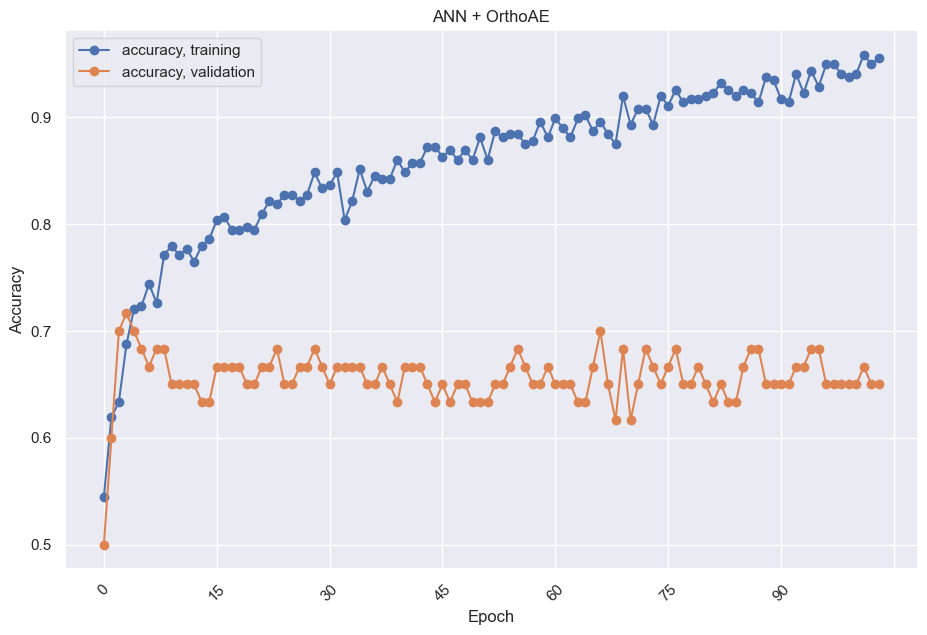

In [260]:
plot_accuracy(history, "ANN + OrthoAE")

### Variational Autoencoder

In [63]:
encoding_dim = X_train.shape[1]//2
input_dim = X_train.shape[1]
batch_size = 100
learning_rate = 0.001
 
# ENCODER
class Encoder_VAE(tf.keras.Model):
    def __init__(self, encoding_dim, input_dim):
        super(Encoder_VAE, self).__init__()
        self.dense1 = layers.Dense(input_dim*2, activation='relu')
        self.dense2 = layers.Dense(input_dim, activation='relu')
        self.fc_mu = layers.Dense(encoding_dim)
        self.fc_logvar = layers.Dense(encoding_dim)
    
    def call(self, x):
        x = self.dense1(x)
        x = layers.Dropout(0.2)(x)
        x = self.dense2(x)
        x = layers.Dropout(0.2)(x)
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        return mu, log_var

# Sampling / Reparameterization "Trick"
def reparameterize(mu, log_var):
    epsilon = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.exp(0.5 * log_var) * epsilon

# DECODER
class Decoder_VAE(tf.keras.Model):
    def __init__(self, encoding_dim, input_dim):
        super(Decoder_VAE, self).__init__()
        self.dense1 = layers.Dense(input_dim, activation='relu')
        self.dense2 = layers.Dense(input_dim*2, activation='relu')
        self.output_layer = layers.Dense(input_dim, activation=None)
    
    def call(self, z):
        x = self.dense1(z)
        x = layers.Dropout(0.2)(x)
        x = self.dense2(x)
        x = layers.Dropout(0.2)(x)
        return self.output_layer(x)

loss_fn = tf.keras.losses.MeanSquaredError()

# Loss Function
def compute_loss_VAE(x, x_recon, mu, log_var):
    # print(x)
    # print(x_recon)
    reconstruction_loss = tf.reduce_mean(loss_fn(x, x_recon))
    kl_divergence = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return reconstruction_loss + kl_divergence

# Instantiate Models:
encoder = Encoder_VAE(encoding_dim, input_dim)
decoder = Decoder_VAE(encoding_dim, input_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# TRAIN LOOPS
def train_VAE(_dataset, epochs=50):
    dataset = tf.data.Dataset.from_tensor_slices(_dataset).batch(batch_size)
    
    for epoch in range(epochs):
        total_loss = 0
        for step, batch in enumerate(dataset):
            with tf.GradientTape() as tape:
                mu, log_var = encoder(batch)
                z = reparameterize(mu, log_var)
                reconstructed = decoder(z)
                loss = compute_loss_VAE(batch, reconstructed, mu, log_var)
            
            gradients = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)
            optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + decoder.trainable_variables))
        
            total_loss += loss
        
        if (epoch+1) % 100 == 0:
            print(f"Epoch {epoch + 1}, Loss: {total_loss / (step + 1):.4f}")

In [ ]:
# Train the VAE
train_VAE(X_train, epochs=500)

mu, log_var = encoder(np.array(X_test))
z = reparameterize(mu, log_var)
test_reconstructed = decoder(z)

test_loss = loss_fn(np.array(X_test), test_reconstructed).numpy()
print(f"\nTest Reconstruction Loss: {test_loss:.4f}")

Epoch 100, Loss: 0.8074
Epoch 200, Loss: 0.7610
Epoch 300, Loss: 0.7414
Epoch 400, Loss: 0.7471
Epoch 500, Loss: 0.6811

Test Reconstruction Loss: 0.7184


In [262]:
mu, log_var = encoder(np.array(X_train))
z_train = reparameterize(mu, log_var)

mu, log_var = encoder(np.array(X_test))
z_test = reparameterize(mu, log_var)

In [263]:
X_train_encoded = z_train.numpy()
X_test_encoded = z_test.numpy()

In [264]:
X_train_augmented = pd.concat([X_train,  pd.DataFrame(X_train_encoded)], axis=1)
X_test_augmented = pd.concat([X_test.reset_index(drop=True),  pd.DataFrame(X_test_encoded)], axis=1)

In [265]:
print(len(np.array(X_train)[0]), len(np.array(X_train_augmented)[0]))
print(len(np.array(X_test)[0]), len(np.array(X_test_augmented)[0]))

11 16
11 16


In [66]:
model = keras.Sequential([
    keras.layers.Dense(X_train_augmented.shape[1]*2, activation='relu', input_shape=(X_train_augmented.shape[1],)),
    keras.layers.Dense(X_train_augmented.shape[1]*2, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(X_train_augmented.shape[1], activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=100,
    restore_best_weights=True
)

In [67]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,145 (8.38 KB)

 Trainable params: 2,145 (8.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
### FIT MODEL ###
history = model.fit(
    X_train_augmented, y_train,
    epochs=2000,
    batch_size=32,
    validation_data=(X_test_augmented, y_test),
    callbacks=[early_stopping],
    verbose=0
)

In [267]:
handle_stats(summary_stats, model, X_test_augmented, y_test, "ANN + VAE")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction: [1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 1 0 1
 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1], shape: (60,) 

True Label: [0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1
 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1], shape: (60,) 

Z-Score: 3.0983866769659336 

P-Value: 0.0019457736937391612 

[[30  5]
 [13 12]]
test accuracy: 0.7
test precision: 0.7017783857729138
test recall: 0.6685714285714286


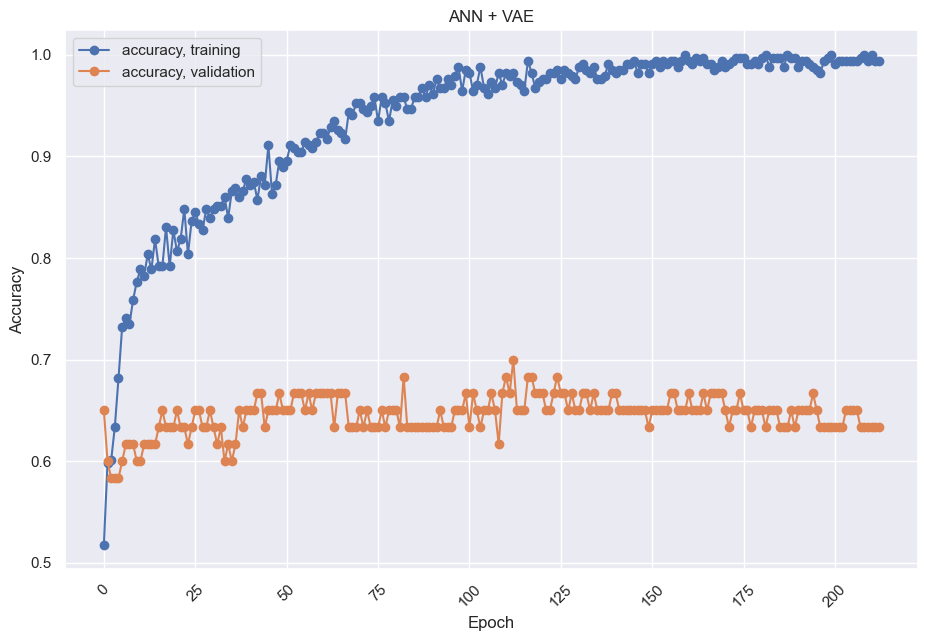

In [268]:
plot_accuracy(history, "ANN + VAE")

## Analysis of Results

### Summary Statistics

Below is a statistical summary of our learning models, including metrics such as accuracy, precision, recall, and the statistical significance of the measured accuracy. To establish a baseline, we first used a linear support vector classifier, both with and without the inclusion of encoded data. For the remaining experiments, we employed an artificial neural network trained on data augmented by different types of autoencoders. These include a traditional autoencoder, a variational autoencoder, and an orthogonality-enforced autoencoder—a novel approach introduced in the referenced study.

In [270]:
# Summary Stats
summarystats = pd.DataFrame(summary_stats)
summarystats.round(2)

,Model,Test Accuracy,Test Precision,Test Recall,P-Value,Is Significant
0,Linear SVC,0.70,0.70,0.67,0.0,True
1,Simple ANN,0.70,0.69,0.68,0.0,True
2,ANN + AE,0.73,0.73,0.71,0.0,True
3,Linear SVC + AE,0.70,0.70,0.67,0.0,True
4,ANN + OrthoAE,0.72,0.72,0.69,0.0,True
5,ANN + VAE,0.70,0.70,0.67,0.0,True


### Hyperparameter Tuning and Model Selection
* Grid search with 10-fold cross-validation was used for the linear SVC to determine optimal hyperparameters.  
* Dropout regularization was applied between layers in both the predictive models and autoencoders.  
* The Adam optimizer was used with a carefully tuned learning rate and decay rate; these settings were kept consistent across all models to ensure comparability.  
* Validation accuracy was used to select the best-fitting model for each training run.

## Wrapping Things Up
##### *Key Conclusions, underperforming models and future improvements*

We began this project with the expectation that autoencoders might extract additional non-linearly separable features not captured by linear models like support vector machines. While none of the artificial neural network (ANN) variants performed worse than the linear SVC, they also did not show any significant performance advantage. Although ANN models appeared to slightly outperform the linear SVC in some cases, this marginal gain could be attributed to potential data leakage, as validation accuracy was used for model selection.

It is commonly understood in machine learning that traditional models tend to outperform deep learning models on tabular data, especially when the data is largely linearly separable. However, in cases where non-linear relationships exist, deep learning models are theoretically better suited to capture those complexities. Since our ANN-based models performed on par with the linear SVC, this suggests that they may have been able to capture some degree of non-linearity in the data.

Additionally, our experiments with various autoencoder architectures—including traditional, variational, and orthogonality-enforced—did not result in significant performance differences compared to the standard ANN. This suggests that autoencoders, in this context, do not offer a distinct advantage in capturing non-linear patterns. However, the orthogonality-enforced autoencoder shows potential as a novel architecture worth further exploration, particularly since it maintained comparable performance to other models.

A key focus of this project was to avoid overfitting in the autoencoder models to reduce redundancy and prevent data leakage. However, applying the same hyperparameters across all models may have caused the variational autoencoder (VAE) to underfit, potentially limiting the performance of the ANN trained on its encoded data. Future work could involve exploring tailored hyperparameter tuning strategies for each autoencoder variant to ensure balanced information gain. Additionally, incorporating other types of autoencoders, such as denoising autoencoders, may offer new insights into improving representation learning in tabular data.

## References
[1] Chicco, D., Jurman, G. Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Med Inform Decis Mak 20, 16 (2020). https://doi.org/10.1186/s12911-020-1023-5

[2] Jaehoon Cha and Jeyan Thiyagalingam. 2023. Orthogonality-enforced latent space in autoencoders: an approach to learning disentangled representations. In Proceedings of the 40th International Conference on Machine Learning (ICML'23), Vol. 202. JMLR.org, Article 157, 3913–3948.

## Try It Out Yourself
[3] Access the Dataset via Kaggle: https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data